# Compare Latent heat flux

Author: Ziqi Yin

Last edited: Oct 7, 2025

## Description

- Data:
    - CESM2-LE: Large Ensemble (LE) using the 50 members that have CMIP6 forcing
- Period: 1940-1969, 2071-2100

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import stats
import seaborn as sns  ### seaborn just makes things pretty -- no new typing
from math import radians, sin, cos, sqrt, atan2

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point
#from holoviews.operation.datashader import datashade, rasterize, regrid

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
def compute_saturation_specific_humidity(TS, PS, Melt):
    """
    Compute saturation specific humidity (qs) using the Flatau scheme for CESM2.

    Parameters:
    - TS: Surface temperature (Kelvin)
    - PS: Surface pressure (Pa)
    - Melt: Snowmelt + Ice melt (kg m^-2 s^-1)

    Returns:
    - qs: Saturation specific humidity (kg/kg)
    """

    # Convert temperature from Kelvin to Celsius
    T_C = TS - 273.15

    # Define Flatau polynomial coefficients for saturation vapor pressure (hPa)
    coef_liquid = [6.1078, 0.4436519, 0.01428946, 0.0002650647, 3.03124e-06]
    coef_ice = [6.1091, 0.4271179, 0.01314537, 0.0002747536, 3.053717e-06]

    # Determine surface type based on melt presence
    is_liquid = (Melt > 0)  # Grid cells with melt are liquid surfaces

    # Compute saturation vapor pressure (hPa)
    es_liquid = coef_liquid[0] + T_C * (coef_liquid[1] + T_C * (coef_liquid[2] + T_C * (coef_liquid[3] + T_C * coef_liquid[4])))
    es_ice = coef_ice[0] + T_C * (coef_ice[1] + T_C * (coef_ice[2] + T_C * (coef_ice[3] + T_C * coef_ice[4])))

    # Select es based on surface type
    es = np.where(is_liquid, es_liquid, es_ice)  # hPa

    # Convert surface pressure from Pa to hPa
    PS_hPa = PS / 100.0

    # Compute saturation specific humidity (kg/kg)
    epsilon = 0.622  # Ratio of gas constants
    qs = (epsilon * es) / (PS_hPa - (1 - epsilon) * es)

    return qs

# Example usage:
# Assuming ds is an xarray dataset containing CESM2 output variables
# ds["qs"] = compute_saturation_specific_humidity(ds["TS"], ds["PS"], ds["QSNOMELT"], ds["QICE_MELT"])
# ds["qs"].attrs["units"] = "kg/kg"

### Read data

In [3]:
## LH related variables
data_dir = '/glade/derecho/scratch/ziqiyin/2023-GrIS-melt-causality/LENS2/mergetime/'

EFLX_LH_TOT_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.EFLX_LH_TOT.194001-196912.nc')['EFLX_LH_TOT'] #[W/m2]
EFLX_LH_TOT_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.EFLX_LH_TOT.206501-210012.nc')['EFLX_LH_TOT']
PCT_LANDUNIT_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.PCT_LANDUNIT.194001-196912.nc')['PCT_LANDUNIT'] #
PCT_LANDUNIT_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.PCT_LANDUNIT.206501-210012.nc')['PCT_LANDUNIT']
Q2M_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.Q2M.194001-196912.nc')['Q2M'] #[kg/kg]
Q2M_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.Q2M.206501-210012.nc')['Q2M']
U10_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.cam.h0.U10.194001-196912.nc')['U10'] #[m/s]
U10_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.cam.h0.U10.206501-210012.nc')['U10']
TS_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.cam.h0.TS.194001-196912.nc')['TS'] #[K]
TS_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.cam.h0.TS.206501-210012.nc')['TS']
PS_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.cam.h0.PS.194001-196912.nc')['PS'] #[Pa]
PS_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.cam.h0.PS.206501-210012.nc')['PS']

dates1 = pd.date_range("1940-01-01", periods=30*12, freq='M')
dates2 = pd.date_range("2065-01-01", periods=36*12, freq='M')

EFLX_LH_TOT_monthly_1940_1969['time'] = dates1
EFLX_LH_TOT_monthly_2065_2100['time'] = dates2
PCT_LANDUNIT_monthly_1940_1969['time'] = dates1
PCT_LANDUNIT_monthly_2065_2100['time'] = dates2
Q2M_monthly_1940_1969['time'] = dates1
Q2M_monthly_2065_2100['time'] = dates2
U10_monthly_1940_1969['time'] = dates1
U10_monthly_2065_2100['time'] = dates2
TS_monthly_1940_1969['time'] = dates1
TS_monthly_2065_2100['time'] = dates2
PS_monthly_1940_1969['time'] = dates1
PS_monthly_2065_2100['time'] = dates2

EFLX_LH_TOT_monthly_2071_2100 = EFLX_LH_TOT_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
PCT_LANDUNIT_monthly_2071_2100 = PCT_LANDUNIT_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
Q2M_monthly_2071_2100 = Q2M_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
U10_monthly_2071_2100 = U10_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
TS_monthly_2071_2100 = TS_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
PS_monthly_2071_2100 = PS_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))

f09_lon = EFLX_LH_TOT_monthly_1940_1969.lon
f09_lat = EFLX_LH_TOT_monthly_1940_1969.lat

In [4]:
U10_monthly_1940_1969['lat'] = f09_lat.values
U10_monthly_2071_2100['lat'] = f09_lat.values
TS_monthly_1940_1969['lat'] = f09_lat.values
TS_monthly_2071_2100['lat'] = f09_lat.values
PS_monthly_1940_1969['lat'] = f09_lat.values
PS_monthly_2071_2100['lat'] = f09_lat.values

In [5]:
## SMB variables
data_dir = '/glade/derecho/scratch/ziqiyin/2023-GrIS-melt-causality/LENS2/mergetime/'

RAIN_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.RAIN.194001-196912.nc')['RAIN'] #[mm/s]
RAIN_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.RAIN.206501-210012.nc')['RAIN']
SNOW_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.SNOW.194001-196912.nc')['SNOW']
SNOW_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.SNOW.206501-210012.nc')['SNOW']
QRUNOFF_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.QRUNOFF.194001-196912.nc')['QRUNOFF']
QRUNOFF_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.QRUNOFF.206501-210012.nc')['QRUNOFF']
QFLX_EVAP_TOT_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.QFLX_EVAP_TOT.194001-196912.nc')['QFLX_EVAP_TOT']
QFLX_EVAP_TOT_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.QFLX_EVAP_TOT.206501-210012.nc')['QFLX_EVAP_TOT']
QSNOMELT_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.QSNOMELT.194001-196912.nc')['QSNOMELT']
QSNOMELT_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.QSNOMELT.206501-210012.nc')['QSNOMELT']
QICE_MELT_monthly_1940_1969 = xr.open_dataset(data_dir+'b.e21.BHISTcmip6.f09_g17.LE2-ensmean.clm2.h0.QICE_MELT.194001-196912.nc')['QICE_MELT']
QICE_MELT_monthly_2065_2100 = xr.open_dataset(data_dir+'b.e21.BSSP370cmip6.f09_g17.LE2-ensmean.clm2.h0.QICE_MELT.206501-210012.nc')['QICE_MELT']

dates1 = pd.date_range("1940-01-01", periods=30*12, freq='M')
dates2 = pd.date_range("2065-01-01", periods=36*12, freq='M')

RAIN_monthly_1940_1969['time'] = dates1
RAIN_monthly_2065_2100['time'] = dates2
SNOW_monthly_1940_1969['time'] = dates1
SNOW_monthly_2065_2100['time'] = dates2
QRUNOFF_monthly_1940_1969['time'] = dates1
QRUNOFF_monthly_2065_2100['time'] = dates2
QFLX_EVAP_TOT_monthly_1940_1969['time'] = dates1
QFLX_EVAP_TOT_monthly_2065_2100['time'] = dates2
QSNOMELT_monthly_1940_1969['time'] = dates1
QSNOMELT_monthly_2065_2100['time'] = dates2
QICE_MELT_monthly_1940_1969['time'] = dates1
QICE_MELT_monthly_2065_2100['time'] = dates2

RAIN_monthly_2071_2100 = RAIN_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
SNOW_monthly_2071_2100 = SNOW_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
QRUNOFF_monthly_2071_2100 = QRUNOFF_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
QFLX_EVAP_TOT_monthly_2071_2100 = QFLX_EVAP_TOT_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
QSNOMELT_monthly_2071_2100 = QSNOMELT_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))
QICE_MELT_monthly_2071_2100 = QICE_MELT_monthly_2065_2100.sel(time=slice('2071-01-01','2100-12-31'))

smb_monthly_1940_1969 = RAIN_monthly_1940_1969 + SNOW_monthly_1940_1969 - QRUNOFF_monthly_1940_1969 - QFLX_EVAP_TOT_monthly_1940_1969
smb_monthly_2071_2100 = RAIN_monthly_2071_2100 + SNOW_monthly_2071_2100 - QRUNOFF_monthly_2071_2100 - QFLX_EVAP_TOT_monthly_2071_2100

Melt_monthly_1940_1969 = QSNOMELT_monthly_1940_1969 + QICE_MELT_monthly_1940_1969
Melt_monthly_2071_2100 = QSNOMELT_monthly_2071_2100 + QICE_MELT_monthly_2071_2100

In [6]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_monthly_1940_1969 = PCT_LANDUNIT_monthly_1940_1969[:,3,:,:]
f09_glacier_frac_monthly_2071_2100 = PCT_LANDUNIT_monthly_2071_2100[:,3,:,:]
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

GrIS_mask_monthly_1940_1969 = f09_GrIS_mask0.values * f09_glacier_frac_monthly_1940_1969 * f09_land_frac.values / 100
GrIS_mask_monthly_2071_2100 = f09_GrIS_mask0.values * f09_glacier_frac_monthly_2071_2100 * f09_land_frac.values / 100

In [7]:
## Area
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

## Calculate

### Monthly time series

In [54]:
## Ablation mask
days_in_month = smb_monthly_1940_1969.time.dt.days_in_month
year = smb_monthly_1940_1969.time.dt.year
smb_yearly_1940_1969 = (smb_monthly_1940_1969 * days_in_month).groupby(year).sum()
smb_yearly_mean_1940_1969 = smb_yearly_1940_1969.mean(dim='year')

days_in_month = smb_monthly_2071_2100.time.dt.days_in_month
year = smb_monthly_2071_2100.time.dt.year
smb_yearly_2071_2100 = (smb_monthly_2071_2100 * days_in_month).groupby(year).sum()
smb_yearly_mean_2071_2100 = smb_yearly_2071_2100.mean(dim='year')

GrIS_ablation_mask_monthly_1940_1969 = GrIS_mask_monthly_1940_1969.where(smb_yearly_mean_1940_1969 < 0)
GrIS_ablation_mask_monthly_2071_2100 = GrIS_mask_monthly_2071_2100.where(smb_yearly_mean_2071_2100 < 0)

In [62]:
## LH averaged over the ablation zone
EFLX_LH_TOT_avg_monthly_1940_1969 = -(EFLX_LH_TOT_monthly_1940_1969 * GrIS_ablation_mask_monthly_1940_1969.values * f09_area).sum(dim=['lon','lat']) / (GrIS_ablation_mask_monthly_1940_1969 * f09_area).sum(dim=['lon','lat'])
EFLX_LH_TOT_avg_monthly_2071_2100 = -(EFLX_LH_TOT_monthly_2071_2100 * GrIS_ablation_mask_monthly_2071_2100.values * f09_area).sum(dim=['lon','lat']) / (GrIS_ablation_mask_monthly_2071_2100 * f09_area).sum(dim=['lon','lat'])

In [67]:
## Climatology seasonal cycle
month = EFLX_LH_TOT_avg_monthly_1940_1969.time.dt.month
EFLX_LH_TOT_avg_clim_monthly_1940_1969 = EFLX_LH_TOT_avg_monthly_1940_1969.groupby(month).mean()

month = EFLX_LH_TOT_avg_monthly_2071_2100.time.dt.month
EFLX_LH_TOT_avg_clim_monthly_2071_2100 = EFLX_LH_TOT_avg_monthly_2071_2100.groupby(month).mean()

### JJA mean fields

In [8]:
QS_monthly_1940_1969 = Q2M_monthly_1940_1969*0
QS_monthly_2071_2100 = Q2M_monthly_2071_2100*0

for i in range(360):
    QS_monthly_1940_1969[i] = compute_saturation_specific_humidity(TS_monthly_1940_1969[i], PS_monthly_1940_1969[i], Melt_monthly_1940_1969[i])
    QS_monthly_2071_2100[i] = compute_saturation_specific_humidity(TS_monthly_2071_2100[i], PS_monthly_2071_2100[i], Melt_monthly_2071_2100[i])

In [9]:
EFLX_LH_TOT_monthly_1940_1969_masked = EFLX_LH_TOT_monthly_1940_1969.where(GrIS_mask_monthly_1940_1969 > 0)
EFLX_LH_TOT_monthly_2071_2100_masked = EFLX_LH_TOT_monthly_2071_2100.where(GrIS_mask_monthly_2071_2100 > 0)
Q2M_monthly_1940_1969_masked = Q2M_monthly_1940_1969.where(GrIS_mask_monthly_1940_1969 > 0)
Q2M_monthly_2071_2100_masked = Q2M_monthly_2071_2100.where(GrIS_mask_monthly_2071_2100 > 0)
U10_monthly_1940_1969_masked = U10_monthly_1940_1969.where(GrIS_mask_monthly_1940_1969 > 0)
U10_monthly_2071_2100_masked = U10_monthly_2071_2100.where(GrIS_mask_monthly_2071_2100 > 0)
QS_monthly_1940_1969_masked = QS_monthly_1940_1969.where(GrIS_mask_monthly_1940_1969 > 0)
QS_monthly_2071_2100_masked = QS_monthly_2071_2100.where(GrIS_mask_monthly_2071_2100 > 0)
TS_monthly_1940_1969_masked = TS_monthly_1940_1969.where(GrIS_mask_monthly_1940_1969 > 0)
TS_monthly_2071_2100_masked = TS_monthly_2071_2100.where(GrIS_mask_monthly_2071_2100 > 0)

In [10]:
def weighted_summer_mean(data):

    # Step 1: Calculate the number of days in each month
    days_in_month = data['time'].dt.days_in_month

    # Step 2: Select only summer months (June, July, August)
    summer_months = data['time'].dt.month.isin([6, 7, 8])

    # Step 3: Multiply the data by the number of days in each month (weighted data)
    weighted_data = data.where(summer_months, drop=True) * days_in_month.where(summer_months, drop=True)

    # Step 4: Calculate the weighted summer sum and total days in the summer
    summer_sum = weighted_data.sum(dim='time')
    total_days_in_summer = days_in_month.where(summer_months, drop=True).sum(dim='time')

    # Step 5: Calculate the weighted summer mean
    weighted_summer_mean = summer_sum / total_days_in_summer

    return weighted_summer_mean

In [11]:
LH_monthly_1940_1969_masked_JJA_mean = - weighted_summer_mean(EFLX_LH_TOT_monthly_1940_1969_masked)
LH_monthly_2071_2100_masked_JJA_mean = - weighted_summer_mean(EFLX_LH_TOT_monthly_2071_2100_masked)
Q2m_monthly_1940_1969_masked_JJA_mean = weighted_summer_mean(Q2M_monthly_1940_1969_masked) * 1000 #[g/kg]
Q2m_monthly_2071_2100_masked_JJA_mean = weighted_summer_mean(Q2M_monthly_2071_2100_masked) * 1000 #[g/kg]
U10m_monthly_1940_1969_masked_JJA_mean = weighted_summer_mean(U10_monthly_1940_1969_masked)
U10m_monthly_2071_2100_masked_JJA_mean = weighted_summer_mean(U10_monthly_2071_2100_masked)
QS_monthly_1940_1969_masked_JJA_mean = weighted_summer_mean(QS_monthly_1940_1969_masked) * 1000 #[g/kg]
QS_monthly_2071_2100_masked_JJA_mean = weighted_summer_mean(QS_monthly_2071_2100_masked) * 1000 #[g/kg]
TS_monthly_1940_1969_masked_JJA_mean = weighted_summer_mean(TS_monthly_1940_1969_masked - 273.15) #[deg C]
TS_monthly_2071_2100_masked_JJA_mean = weighted_summer_mean(TS_monthly_2071_2100_masked - 273.15) #[deg C]

In [12]:
dQ_monthly_1940_1969_masked_JJA_mean = Q2m_monthly_1940_1969_masked_JJA_mean - QS_monthly_1940_1969_masked_JJA_mean
dQ_monthly_2071_2100_masked_JJA_mean = Q2m_monthly_2071_2100_masked_JJA_mean - QS_monthly_2071_2100_masked_JJA_mean

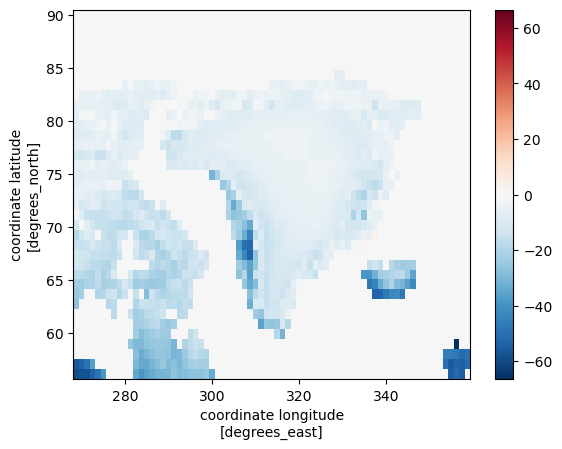

In [20]:
LH_monthly_1940_2014_JJA_mean[155:,215:].plot(vmin);

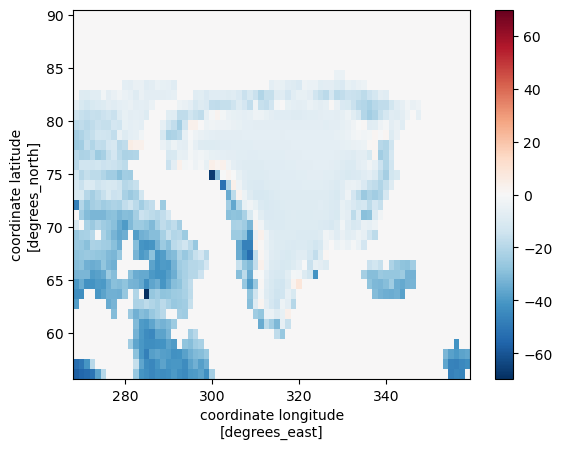

In [22]:
LH_monthly_2051_2100_JJA_mean[155:,215:].plot();

## Plot

### Monthly time series

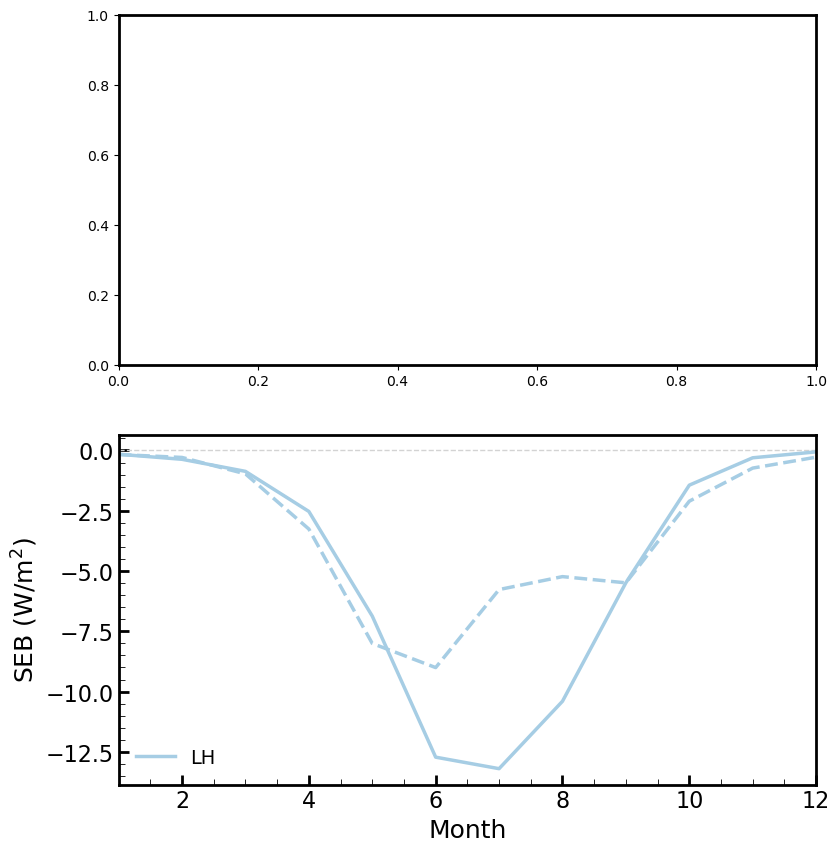

In [68]:
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(2, 1)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_title = 18
size_tick = 16
size_label = 18
size_legend = 14
width_line = 2.5
width_box = 1.9

###################################
ax1 = plt.subplot(gs[0])

month_in_year = EFLX_LH_TOT_avg_clim_monthly_1940_1969.month
#plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
#ax1.plot(month_in_year, F09_GrIS_melt_monthly_1940_2014_topmelt_climo, color="black", linewidth=width_line, label="CESM2-F09")
#ax1.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

#ax1.set_xlim([1, 12])
#ax1.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
#ax1.set_xlabel("Month", fontsize=size_label)
#ax1.set_ylabel("Melt (Gt/day)", fontsize=size_label)
#ax1.xaxis.set_minor_locator(AutoMinorLocator())
#ax1.yaxis.set_minor_locator(AutoMinorLocator())
#ax1.tick_params(which="major", length=7, width=2, direction="in")
#ax1.tick_params(which="minor", length=4, direction="in")
# ax1.set_yticks([-1000, -500, 0, 500])
#ax1.tick_params(labelsize=size_tick)

###################################
ax2 = plt.subplot(gs[1])

plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
#ax2.plot(month_in_year, F09_GrIS_SWn_monthly_1940_2014_topmelt_climo, color="#EEC79F", linewidth=width_line, label="SWn")

#ax2.plot(month_in_year, F09_GrIS_LWn_monthly_1940_2014_topmelt_climo, color="#F1DFA4", linewidth=width_line, label="LWn")

#ax2.plot(month_in_year, F09_GrIS_SH_monthly_1940_2014_topmelt_climo, color="#74B69F", linewidth=width_line, label="SH")

ax2.plot(month_in_year, EFLX_LH_TOT_avg_clim_monthly_1940_1969, color="#A6CDE4", linewidth=width_line, label="LH")
ax2.plot(month_in_year, EFLX_LH_TOT_avg_clim_monthly_2071_2100, color="#A6CDE4", linestyle='--', linewidth=width_line)

ax2.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax2.set_xlim([1, 12])
#ax2.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
ax2.set_xlabel("Month", fontsize=size_label)
ax2.set_ylabel("SEB (W/m$^2$)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
# ax2.set_yticks([-1000, -500, 0, 500])
ax2.tick_params(labelsize=size_tick)

plt.savefig(
    home_dir+'2023-GrIS-melt-causality/plot/physics/tseries_melt_SEB_seasonal_variation_1940-1969_2071-2100.png',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

### JJA mean fields

In [13]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

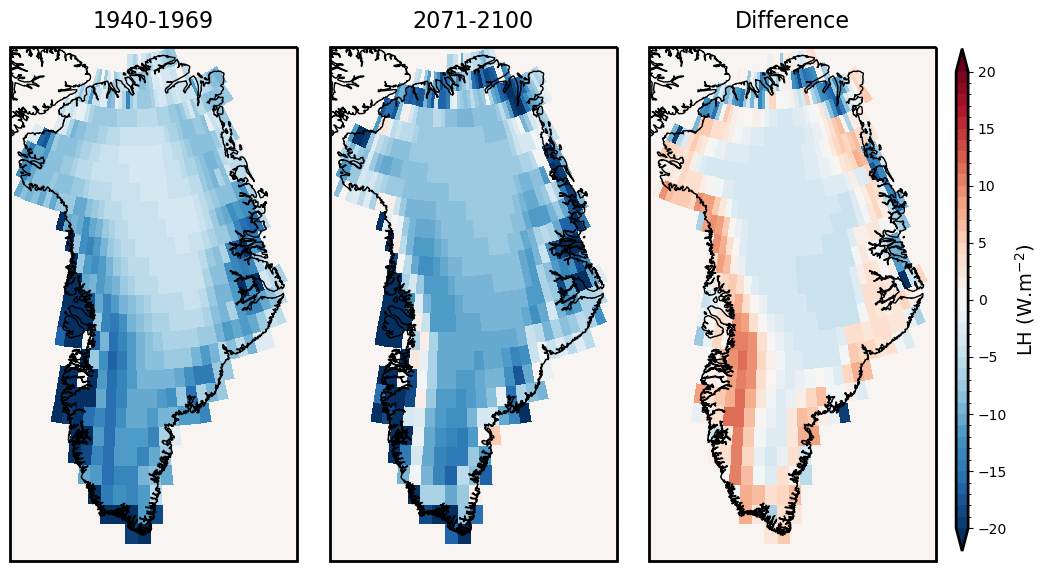

In [115]:
# LH
fig = plt.figure(figsize = (12,6.67))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-20.,20.1,1.)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-20.,20.1,5.)

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, LH_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('1940-1969', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, LH_monthly_2071_2100_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('2071-2100', fontsize = 16)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon, f09_lat, LH_monthly_2071_2100_masked_JJA_mean-LH_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Difference', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.125, 0.01, 0.753])
cb = fig.colorbar(im1, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='LH (W.$\mathregular{m^{-2}}$)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2023-GrIS-melt-causality/physics/Map_LENS2_LH_LH_diff_1940-1969_2071-2100_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

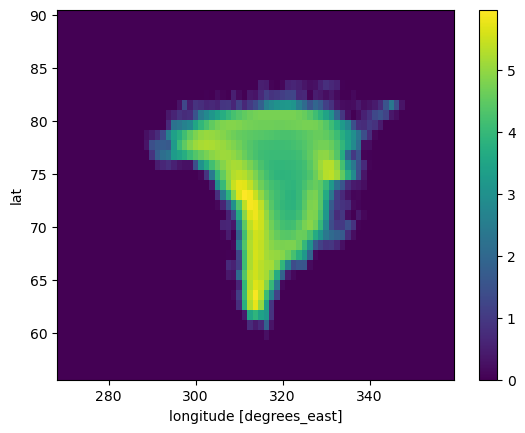

In [69]:
U10m_monthly_1940_2014_masked_JJA_mean[155:,215:].plot();

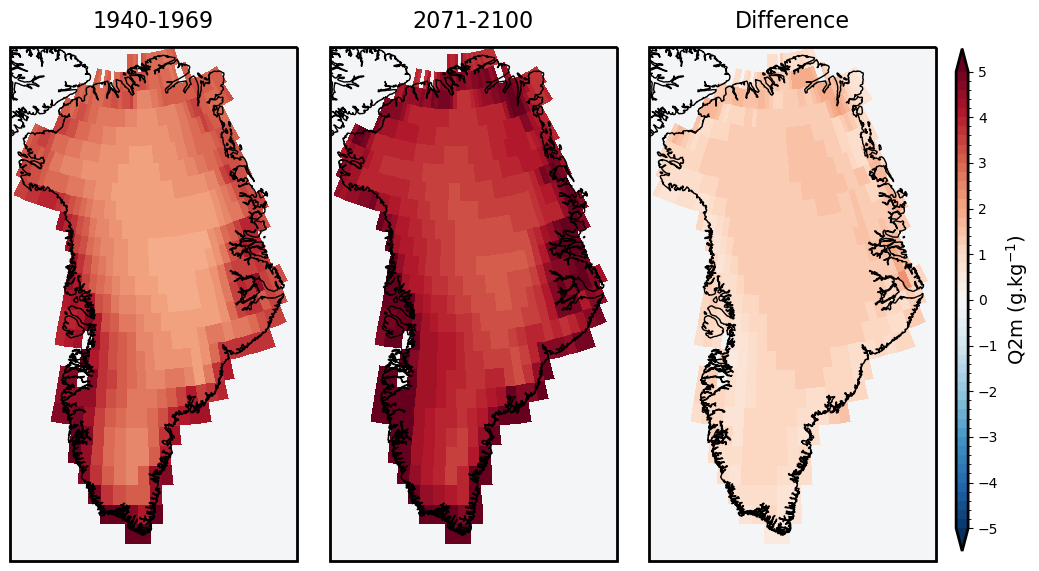

In [116]:
# Q2m
fig = plt.figure(figsize = (12,6.67))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-5.,5.1,0.2)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-5.,5.1,1.)

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, Q2m_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('1940-1969', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, Q2m_monthly_2071_2100_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('2071-2100', fontsize = 16)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon, f09_lat, Q2m_monthly_2071_2100_masked_JJA_mean-Q2m_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Difference', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.125, 0.01, 0.753])
cb = fig.colorbar(im1, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='Q2m (g.$\mathregular{kg^{-1}}$)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2023-GrIS-melt-causality/physics/Map_LENS2_Q2m_Q2m_diff_1940-1969_2071-2100_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

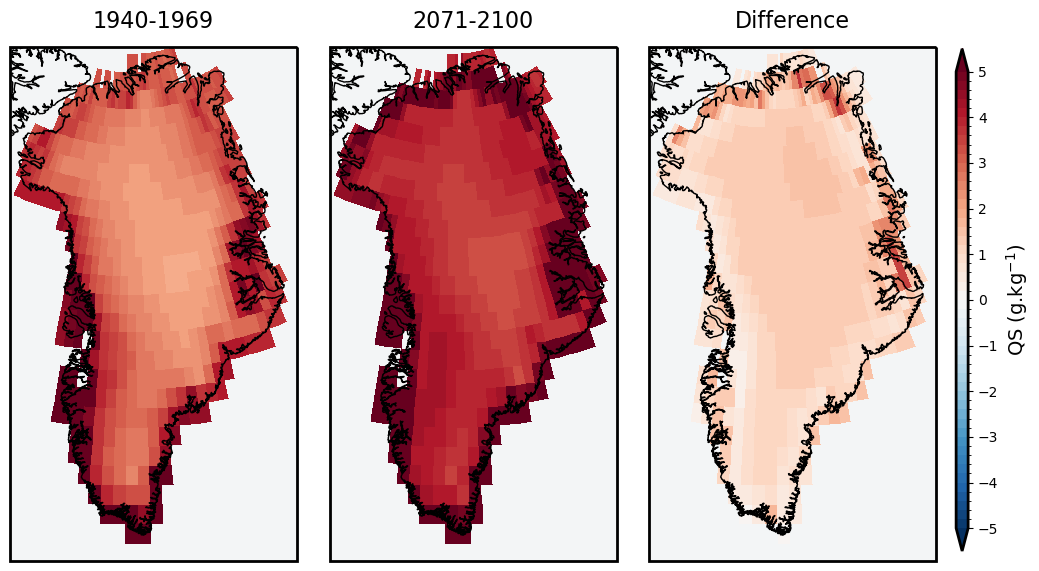

In [117]:
# QS
fig = plt.figure(figsize = (12,6.67))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-5.,5.1,0.2)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-5.,5.1,1.)

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, QS_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('1940-1969', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, QS_monthly_2071_2100_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('2071-2100', fontsize = 16)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon, f09_lat, QS_monthly_2071_2100_masked_JJA_mean-QS_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Difference', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.125, 0.01, 0.753])
cb = fig.colorbar(im1, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='QS (g.$\mathregular{kg^{-1}}$)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2023-GrIS-melt-causality/physics/Map_LENS2_QS_QS_diff_1940-1969_2071-2100_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

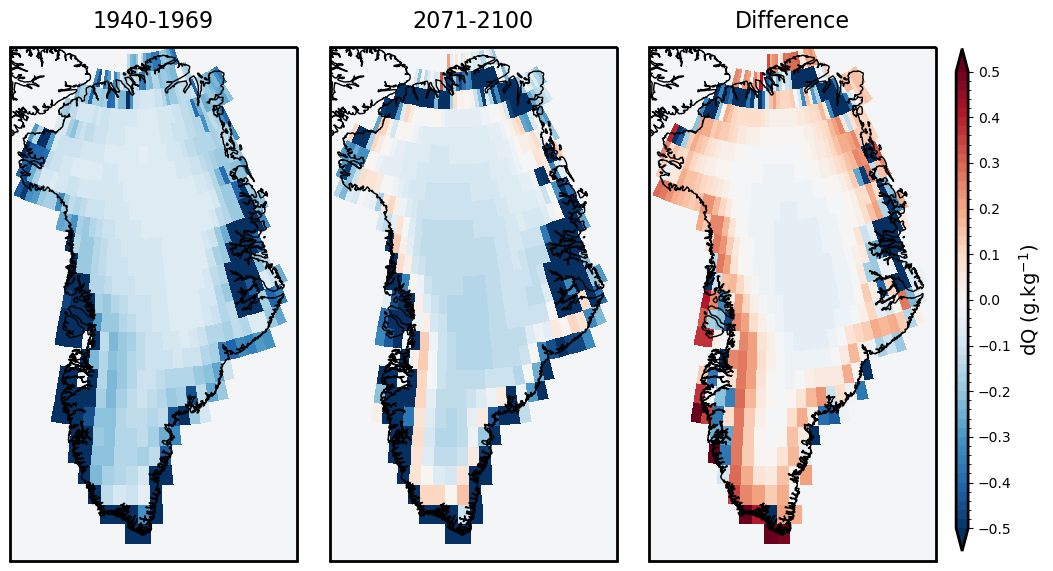

In [120]:
# dQ
fig = plt.figure(figsize = (12,6.67))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-0.5,0.51,0.02)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-0.5,0.51,0.1)

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, dQ_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('1940-1969', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, dQ_monthly_2071_2100_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('2071-2100', fontsize = 16)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon, f09_lat, dQ_monthly_2071_2100_masked_JJA_mean-dQ_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Difference', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.125, 0.01, 0.753])
cb = fig.colorbar(im1, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='dQ (g.$\mathregular{kg^{-1}}$)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2023-GrIS-melt-causality/physics/Map_LENS2_dQ_dQ_diff_1940-1969_2071-2100_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

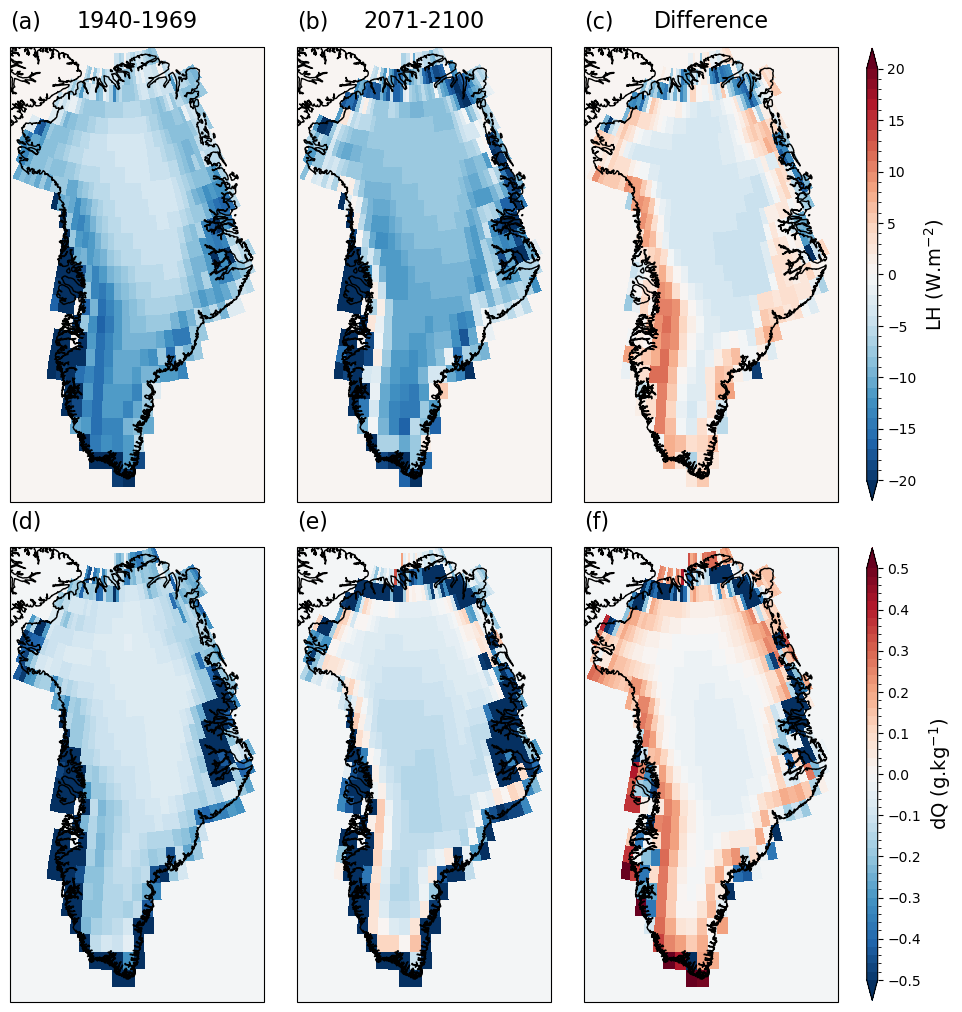

In [28]:
# LH and dQ
fig = plt.figure(figsize = (11,12.4))
gs=GridSpec(2,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
# LH
cmap1 = plt.cm.RdBu_r
bounds1 = np.arange(-20.,20.1,1.)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-20.,20.1,5.)

# dQ
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-0.5,0.51,0.02)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-0.5,0.51,0.1)

# LH
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, LH_monthly_1940_1969_masked_JJA_mean, cmap=cmap1, norm=norm1, transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('(a)', loc='left', fontsize = 16)
plt.title('1940-1969', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, LH_monthly_2071_2100_masked_JJA_mean, cmap=cmap1, norm=norm1, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('(b)', loc='left', fontsize = 16)
plt.title('2071-2100', fontsize = 16)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon, f09_lat, LH_monthly_2071_2100_masked_JJA_mean-LH_monthly_1940_1969_masked_JJA_mean, cmap=cmap1, norm=norm1, transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('(c)', loc='left', fontsize = 16)
plt.title('Difference', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.5143, 0.01, 0.365])
cb = fig.colorbar(im1, cax=cbar_ax, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb.set_label(label='LH (W.$\mathregular{m^{-2}}$)', size=14)
cb.ax.tick_params(labelsize=10)

# dQ
ax4 = plt.subplot(gs[3], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.pcolormesh(f09_lon, f09_lat, dQ_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('(d)', loc='left', fontsize = 16)
#plt.title('1940-1969', fontsize = 16)

ax5 = plt.subplot(gs[4], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84])
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.pcolormesh(f09_lon, f09_lat, dQ_monthly_2071_2100_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('(e)', loc='left', fontsize = 16)
#plt.title('2071-2100', fontsize = 16)

ax6 = plt.subplot(gs[5], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84])
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.pcolormesh(f09_lon, f09_lat, dQ_monthly_2071_2100_masked_JJA_mean-dQ_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('(f)', loc='left', fontsize = 16)
#plt.title('Difference', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.1113, 0.01, 0.365])
cb = fig.colorbar(im4, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='dQ (g.$\mathregular{kg^{-1}}$)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.03,
                    hspace=0.1)

plt.savefig(home_dir+'2023-GrIS-melt-causality/physics/Map_LENS2_LH_LH_diff_dQ_dQ_diff_1940-1969_2071-2100_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

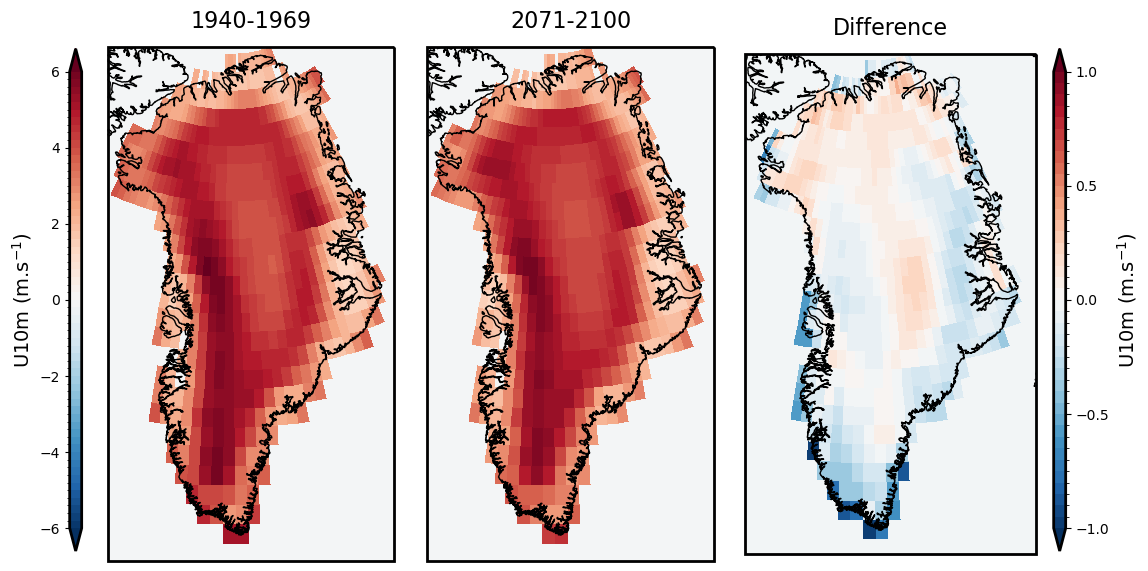

In [121]:
# U10
fig = plt.figure(figsize = (12,6.67))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.RdBu_r
bounds1 = np.arange(-6.,6.1,0.2)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-6.,6.1,2.)

cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-1.,1.01,0.05)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-1.,1.01,0.5)

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, U10m_monthly_1940_1969_masked_JJA_mean, cmap=cmap1, norm=norm1, transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('1940-1969', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, U10m_monthly_2071_2100_masked_JJA_mean, cmap=cmap1, norm=norm1, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('2071-2100', fontsize = 16)

# colorbar
cbar_ax1 = fig.add_axes([0.095, 0.125, 0.01, 0.753])
cb1 = fig.colorbar(im2, cax=cbar_ax1, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb1.set_label(label='U10m (m.$\mathregular{s^{-1}}$)', size=14)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.yaxis.set_label_position('left')

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56.5, -29.5, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon, f09_lat, U10m_monthly_2071_2100_masked_JJA_mean-U10m_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Difference', fontsize = 16)

# colorbar
cbar_ax2 = fig.add_axes([0.915, 0.125, 0.01, 0.753])
cb2 = fig.colorbar(im3, cax=cbar_ax2, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb2.set_label(label='U10m (m.$\mathregular{s^{-1}}$)', size=14)
cb2.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2023-GrIS-melt-causality/physics/Map_LENS2_U10m_U10m_diff_1940-1969_2071-2100_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

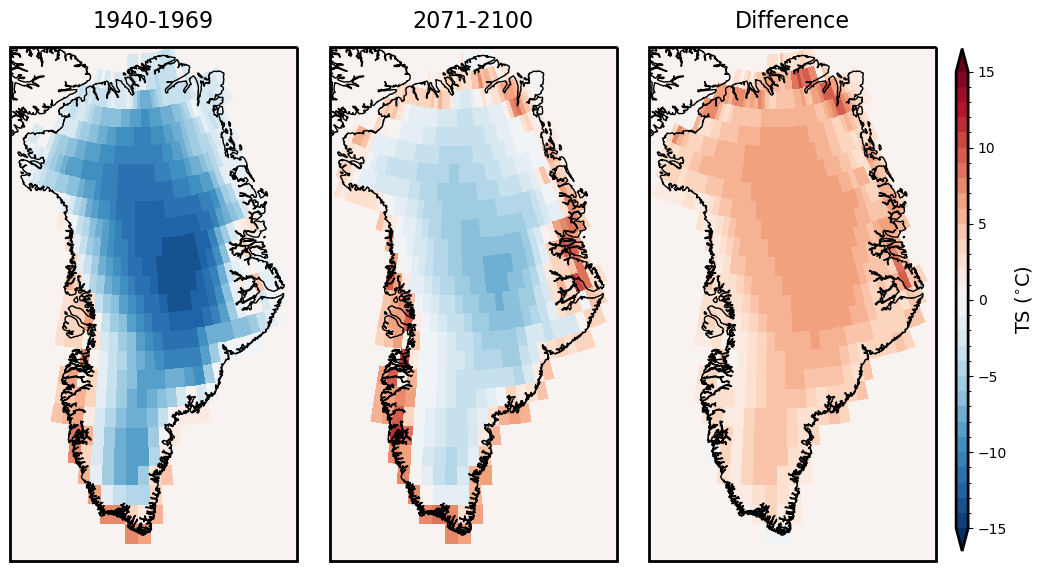

In [114]:
# TS
fig = plt.figure(figsize = (12,6.67))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-15.,15.1,1.)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-15.,15.1,5.)

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.pcolormesh(f09_lon, f09_lat, TS_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('1940-1969', fontsize = 16)

ax2 = plt.subplot(gs[1], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84])
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.pcolormesh(f09_lon, f09_lat, TS_monthly_2071_2100_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('2071-2100', fontsize = 16)

ax3 = plt.subplot(gs[2], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84])
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.pcolormesh(f09_lon, f09_lat, TS_monthly_2071_2100_masked_JJA_mean-TS_monthly_1940_1969_masked_JJA_mean, cmap=cmap2, norm=norm2, transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('Difference', fontsize = 16)

# colorbar
cbar_ax = fig.add_axes([0.915, 0.125, 0.01, 0.753])
cb = fig.colorbar(im1, cax=cbar_ax, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb.set_label(label='TS ($\mathregular{^{\circ}}$C)', size=14)
cb.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.1,
                    hspace=0.03)

plt.savefig(home_dir+'2023-GrIS-melt-causality/physics/Map_LENS2_TS_TS_diff_1940-1969_2071-2100_JJA.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

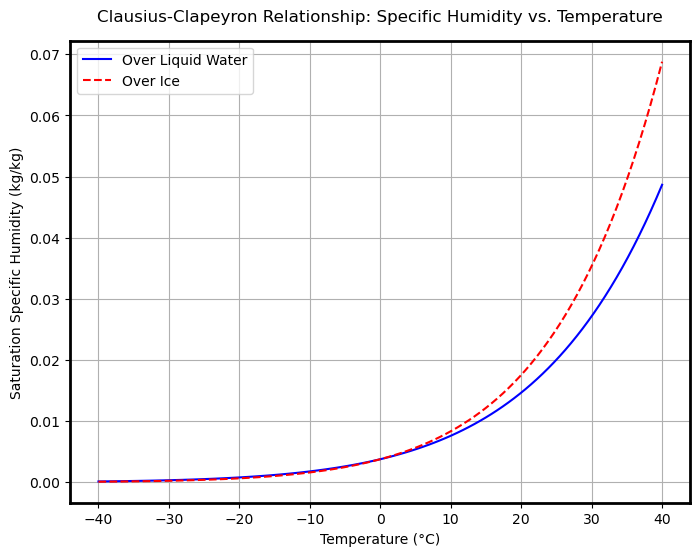

In [89]:
# Define temperature range (-40°C to 40°C) in Kelvin
T_C = np.linspace(-40, 40, 100)  # Celsius
T_K = T_C + 273.15  # Convert to Kelvin

# Constants for Clausius-Clapeyron equation
L_v = 2.5e6  # Latent heat of vaporization (J/kg)
L_s = 2.83e6  # Latent heat of sublimation (J/kg)
R_v = 461.5  # Gas constant for water vapor (J/kg/K)
P_0 = 1013.25  # Reference pressure (hPa)

# Compute saturation vapor pressure (hPa) using Clausius-Clapeyron equation
e_s_liquid = 6.112 * np.exp((L_v / R_v) * ((1 / 273.15) - (1 / T_K)))
e_s_ice = 6.112 * np.exp((L_s / R_v) * ((1 / 273.15) - (1 / T_K)))

# Convert to saturation specific humidity (kg/kg)
epsilon = 0.622  # Ratio of gas constants
q_s_liquid = (epsilon * e_s_liquid) / (P_0 - (1 - epsilon) * e_s_liquid)
q_s_ice = (epsilon * e_s_ice) / (P_0 - (1 - epsilon) * e_s_ice)

# Plot the relationship
plt.figure(figsize=(8, 6))
plt.plot(T_C, q_s_liquid, label="Over Liquid Water", color="blue")
plt.plot(T_C, q_s_ice, label="Over Ice", color="red", linestyle="dashed")

plt.xlabel("Temperature (°C)")
plt.ylabel("Saturation Specific Humidity (kg/kg)")
plt.title("Clausius-Clapeyron Relationship: Specific Humidity vs. Temperature")
plt.legend()
plt.grid()
plt.show()